# Papcorns Data Scientist Task - Getting Started

This notebook will help you get started with the Papcorns data scientist technical assessment. We'll show you how to:
1. Install requirements and do the imports
2. Connect to the SQLite database
3. Load the data into pandas DataFrames

First, let's import the required libraries:

## Installing Requirements

Let's install the required libraries:

In [2]:
!pip install -r requirements.txt


[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: C:\Users\mehme\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## Imports

Let's do the imports:

In [3]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# # Set plotting style
# plt.style.use('seaborn')
# sns.set_palette('deep')

## Connecting to the Database

Let's establish a connection to the SQLite database:

In [4]:
# Connect to the SQLite database
conn = sqlite3.connect('papcorns.sqlite')

## Exploring the Data Structure

Let's look at the structure of our tables:

In [5]:
users_df = pd.read_sql_query("SELECT * FROM users LIMIT 5;", conn)
print("Users table preview:")
display(users_df)

events_df = pd.read_sql_query("SELECT * FROM user_events LIMIT 5;", conn)
print("\nUser events table preview:")
display(events_df)

Users table preview:


,id,created_at,attribution_source,country,name
0,1,2024-05-07T00:00:00,instagram,US,Eve Brown
1,2,2024-10-12T00:00:00,instagram,NL,Frank Moore
2,3,2024-10-15T00:00:00,tiktok,TR,Ivy Anderson
3,4,2024-08-28T00:00:00,tiktok,TR,Alice Brown
4,5,2024-04-03T00:00:00,organic,NL,Bob Moore



User events table preview:


,id,created_at,user_id,event_name,amount_usd
0,1,2024-05-07T00:00:00,1,app_install,None
1,2,2024-05-12T00:00:00,1,trial_started,None
2,3,2024-05-24T00:00:00,1,trial_cancelled,None
3,4,2024-10-12T00:00:00,2,app_install,None
4,5,2024-10-13T00:00:00,2,trial_started,None


In [6]:
# SQL query to calculate core tasks (total revenue per country)
sp_calculation_query = """
SELECT 
    u.country,
    COUNT(CASE WHEN e.event_name = 'subscription_started' THEN 1 END) AS subscriptions_started,
    COUNT(CASE WHEN e.event_name = 'subscription_renewed' THEN 1 END) AS subscriptions_renewed,
    SUM(CASE WHEN e.event_name IN ('subscription_started', 'subscription_renewed') THEN e.amount_usd ELSE 0 END) AS total_revenue
FROM 
    users u
JOIN 
    user_events e ON u.id = e.user_id
WHERE 
    e.event_name IN ('subscription_started', 'subscription_renewed')
GROUP BY 
    u.country;
"""

sp_result = pd.read_sql_query(sp_calculation_query, conn)

sp_result


,country,subscriptions_started,subscriptions_renewed,total_revenue
0,NL,149,222,3335.29
1,TR,171,285,2275.44
2,US,161,243,4035.96


In [7]:

trial_count_query = """
SELECT 
    COUNT(*) AS total_trials
FROM 
    user_events e
JOIN 
    users u ON e.user_id = u.id
WHERE 
    u.attribution_source = 'instagram' AND e.event_name = 'trial_started';
"""
trial_count_result = pd.read_sql_query(trial_count_query, conn)

print(trial_count_result)

   total_trials
0           210


In [8]:
users_df['acquisition_channel'] = users_df['attribution_source'].apply(
    lambda x: 'Paid' if x in ['instagram', 'tiktok'] else 'Organic'
)

print(users_df)

   id           created_at attribution_source country          name  \
0   1  2024-05-07T00:00:00          instagram      US     Eve Brown   
1   2  2024-10-12T00:00:00          instagram      NL   Frank Moore   
2   3  2024-10-15T00:00:00             tiktok      TR  Ivy Anderson   
3   4  2024-08-28T00:00:00             tiktok      TR   Alice Brown   
4   5  2024-04-03T00:00:00            organic      NL     Bob Moore   

  acquisition_channel  
0                Paid  
1                Paid  
2                Paid  
3                Paid  
4             Organic  


In [9]:
#end ile kıyasla

overall_conversion_rate_query = """
WITH trial_users AS (
    SELECT DISTINCT user_id
    FROM user_events
    WHERE event_name = 'trial_started'
),
subscription_users AS (
    SELECT DISTINCT user_id
    FROM user_events
    WHERE event_name = 'subscription_started'
)
SELECT 
    (COUNT(DISTINCT s.user_id) * 1.0 / COUNT(DISTINCT t.user_id)) * 100 AS overall_conversion_rate
FROM 
    trial_users t
JOIN 
    subscription_users s ON t.user_id = s.user_id;
"""

conversion_rate_by_source_query = """
WITH trial_users AS (
    SELECT user_id, attribution_source
    FROM user_events e
    JOIN users u ON e.user_id = u.id
    WHERE event_name = 'trial_started'
),
subscription_users AS (
    SELECT user_id
    FROM user_events
    WHERE event_name = 'subscription_started'
)
SELECT 
    t.attribution_source,
    (COUNT(DISTINCT s.user_id) * 1.0 / COUNT(DISTINCT t.user_id)) * 100 AS conversion_rate_by_source
FROM 
    trial_users t
JOIN 
    subscription_users s ON t.user_id = s.user_id
GROUP BY 
    t.attribution_source;
"""

overall_conversion_rate = pd.read_sql_query(overall_conversion_rate_query, conn)
conversion_rate_by_source = pd.read_sql_query(conversion_rate_by_source_query, conn)



In [10]:
overall_conversion_rate


,overall_conversion_rate
0,100.0


In [11]:
conversion_rate_by_source

,attribution_source,conversion_rate_by_source
0,instagram,100.0
1,organic,100.0
2,tiktok,100.0


In [12]:
median_subscription_duration_query = """
WITH subscription_data AS (
    SELECT 
        u.country,
        JULIANDAY(e2.created_at) - JULIANDAY(e1.created_at) AS subscription_duration_days
    FROM 
        user_events e1
    JOIN 
        user_events e2 ON e1.user_id = e2.user_id
    JOIN 
        users u ON e1.user_id = u.id
    WHERE 
        e1.event_name = 'subscription_started' AND e2.event_name = 'subscription_renewed'
)
SELECT 
    country,
    AVG(subscription_duration_days) / 30 AS median_subscription_duration_months
FROM (
    SELECT 
        country, 
        subscription_duration_days, 
        ROW_NUMBER() OVER (PARTITION BY country ORDER BY subscription_duration_days) AS row_num,
        COUNT(*) OVER (PARTITION BY country) AS total_count
    FROM subscription_data
) AS ranked_data
WHERE 
    row_num = (total_count + 1) / 2 OR row_num = total_count / 2
GROUP BY 
    country;

"""

median_subscription_duration = pd.read_sql_query(median_subscription_duration_query, conn)

median_subscription_duration


,country,median_subscription_duration_months
0,NL,2.0
1,TR,2.0
2,US,1.0


In [13]:
ltv_by_country_query = """
WITH user_revenue AS (
    SELECT 
        u.country,
        e.user_id,
        SUM(amount_usd) AS ltv
    FROM 
        user_events e
    JOIN 
        users u ON e.user_id = u.id
    GROUP BY 
        u.country, e.user_id
)
SELECT 
    country,
    AVG(ltv) AS average_ltv
FROM 
    user_revenue
GROUP BY 
    country;
"""

ltv_by_country = pd.read_sql_query(ltv_by_country_query, conn)

ltv_by_country


,country,average_ltv
0,NL,22.384497
1,TR,13.306667
2,US,25.068075


In [14]:
#unıqe eventlrin ismler

In [15]:
uniqe_event="Select DISTINCT(event_name) FROM user_events"

In [16]:
users_query = """
SELECT * FROM users;
"""
users_df = pd.read_sql_query(users_query, conn)
user_events_query = """
SELECT * FROM user_events;
"""
user_events_df = pd.read_sql_query(user_events_query, conn)


In [17]:
user_data = pd.merge(user_events_df, users_df, left_on='user_id', right_on='id', how='left')


In [18]:
def correct_date_format(date_str):
    date = pd.to_datetime(date_str)
    return pd.to_datetime(date.strftime('%Y-%m-%d'))

In [19]:
def extract_features(user_id):
    subscription_start_query = f"""
    SELECT created_at 
    FROM user_events 
    WHERE user_id = {user_id} AND event_name = 'subscription_started'
    ORDER BY created_at ASC
    LIMIT 1;
    """
    subscription_start_date = pd.read_sql_query(subscription_start_query, conn)

    subscription_renew_query = f"""
    SELECT created_at 
    FROM user_events 
    WHERE user_id = {user_id} AND event_name = 'subscription_renewed'
    ORDER BY created_at ASC
    LIMIT 1;
    """
    subscription_renew_date = pd.read_sql_query(subscription_renew_query, conn)

    # Abonelik süresi
    if not subscription_start_date.empty and not subscription_renew_date.empty:
        start_date = pd.to_datetime(subscription_start_date['created_at'].iloc[0])
        renew_date = pd.to_datetime(subscription_renew_date['created_at'].iloc[0])
        subscription_duration_days = (renew_date - start_date).days
    else:
        subscription_duration_days = None

    # Son etkinlik tarihi
    last_event_query = f"""
    SELECT MAX(created_at) AS last_event_date
    FROM user_events
    WHERE user_id = {user_id};
    """
    last_event_date = pd.read_sql_query(last_event_query, conn)

    # Deneme başlatma durumu
    trial_started_query = f"""
    SELECT COUNT(*) AS trial_started_count
    FROM user_events 
    WHERE user_id = {user_id} AND event_name = 'trial_started';
    """
    trial_started_count = pd.read_sql_query(trial_started_query, conn)

    trial_started = trial_started_count['trial_started_count'].iloc[0] > 0

    # Abonelik başlatma durumu
    subscription_started_query = f"""
    SELECT COUNT(*) AS subscription_started_count
    FROM user_events 
    WHERE user_id = {user_id} AND event_name = 'subscription_started';
    """
    subscription_started_count = pd.read_sql_query(subscription_started_query, conn)

    subscription_started = subscription_started_count['subscription_started_count'].iloc[0] > 0

    # Abonelik yenileme durumu
    subscription_renewed_query = f"""
    SELECT COUNT(*) AS subscription_renewed_count
    FROM user_events 
    WHERE user_id = {user_id} AND event_name = 'subscription_renewed';
    """
    subscription_renewed_count = pd.read_sql_query(subscription_renewed_query, conn)

    subscription_renewed = subscription_renewed_count['subscription_renewed_count'].iloc[0] > 0

    if not last_event_date.empty:
        last_event_date_str = correct_date_format(last_event_date['last_event_date'].iloc[0])
    else:
        last_event_date_str = 0

    today = pd.to_datetime("today")
    day=(today - last_event_date_str).days
    # Özellikler
    user_features = {
        'user_id': user_id,
        'subscription_duration_days': subscription_duration_days,
        'last_event_date': day,
        'trial_started': trial_started,
        'subscription_started': subscription_started,
        'subscription_renewed': subscription_renewed
    }
    return user_features

In [20]:
user_features_list = []
for user_id in users_df['id']:
    features = extract_features(user_id)
    user_features_list.append(features)

user_features_df = pd.DataFrame(user_features_list)

In [21]:
user_features_df['subscription_duration_days']=user_features_df['subscription_duration_days'].fillna(user_features_df['subscription_duration_days'].median())

In [22]:
user_features_df

,user_id,subscription_duration_days,last_event_date,trial_started,subscription_started,subscription_renewed
0,1,30.0,333,True,False,False
1,2,30.0,69,True,True,True
2,3,30.0,92,True,True,True
3,4,30.0,228,True,False,False
4,5,30.0,384,False,False,False
...,...,...,...,...,...,...
997,998,30.0,80,False,False,False
998,999,30.0,45,True,True,True
999,1000,30.0,56,True,False,False
1000,1001,30.0,56,True,True,False


In [23]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [24]:
X = user_features_df.drop(columns=['user_id', 'subscription_renewed'])  # Özellikler
y = user_features_df['subscription_renewed']  # Etiket

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)


params = {
    'objective': 'binary',  
    'metric': 'binary_error',  
    'boosting_type': 'gbdt', 
    'num_leaves': 31,  
    'learning_rate': 0.05,  
    'feature_fraction': 0.9,  
}

In [27]:


# Modeli eğitelim
lgb_model = lgb.train(params, train_data, num_boost_round=100, 
                      valid_sets=[test_data], 
                      callbacks=[
        lgb.early_stopping(stopping_rounds=3),
    ])  # 10'luk adımlarla çıktı alır

# Test seti üzerinde tahmin yapalım
y_pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
y_pred_binary = (y_pred > 0.5).astype(int)  # 0.5'ten büyükse churn


[LightGBM] [Info] Number of positive: 297, number of negative: 504
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 249
[LightGBM] [Info] Number of data points in the train set: 801, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370787 -> initscore=-0.528844
[LightGBM] [Info] Start training from score -0.528844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 3 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[1]	valid_0's binary_error: 0.363184


In [28]:


# Sonuçları değerlendirelim
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"LightGBM Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred_binary))


LightGBM Accuracy: 0.64
Classification Report:
               precision    recall  f1-score   support

       False       0.64      1.00      0.78       128
        True       0.00      0.00      0.00        73

    accuracy                           0.64       201
   macro avg       0.32      0.50      0.39       201
weighted avg       0.41      0.64      0.50       201



C:\Users\mehme\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mehme\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mehme\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classificati

In [29]:
train_columns = X_train.columns

In [30]:
clark_kent_features = user_features_df[user_features_df['user_id'] == user_id][train_columns]

In [31]:
clark_kent_features

,subscription_duration_days,last_event_date,trial_started,subscription_started
1001,30.0,56,False,False


In [32]:

churn_probability = lgb_model.predict(clark_kent_features, num_iteration=lgb_model.best_iteration)[0]
print(f"Clark Kent'in churn olasılığı: {churn_probability:.2f}")

Clark Kent'in churn olasılığı: 0.35


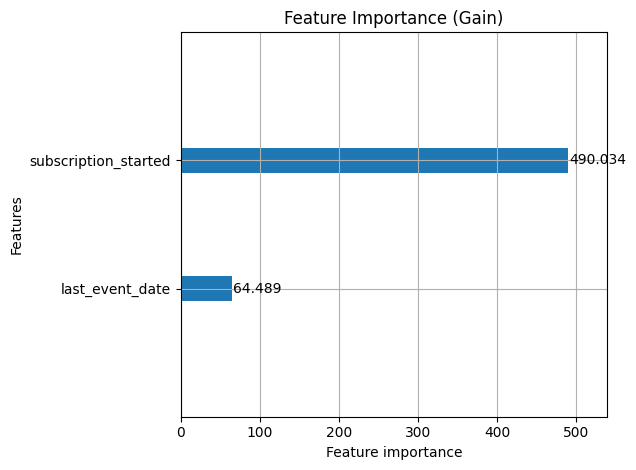

In [33]:
import matplotlib.pyplot as plt
import lightgbm as lgb

lgb.plot_importance(lgb_model, max_num_features=15, importance_type='gain')
plt.title("Feature Importance (Gain)")
plt.tight_layout()
plt.show()


In [34]:
!pip install shap
import shap

# SHAP açıklayıcıyı oluştur
explainer = shap.TreeExplainer(lgb_model)

# Clark Kent için SHAP değerlerini hesapla
shap_values = explainer.shap_values(clark_kent_features)

# SHAP görselleştirme
shap.initjs()
shap.force_plot(
    explainer.expected_value[1],  # Class 1: churn
    shap_values[1],               # Clark Kent için churn'e katkı yapan değerler
    clark_kent_features           # Özellik değerleri
)



[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: C:\Users\mehme\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
C:\Users\mehme\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


IndexError: invalid index to scalar variable.

In [ ]:

import shap

# SHAP için explainer tanımla
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(clark_kent_features)

# Clark Kent için SHAP özeti
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], clark_kent_features)


C:\Users\mehme\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


IndexError: invalid index to scalar variable.

In [35]:
query = """
SELECT
    u.id as user_id,
    u.country,
    u.attribution_source,
    SUM(CASE WHEN e.amount_usd IS NOT NULL THEN e.amount_usd ELSE 0 END) as total_amount_usd,
    COUNT(e.id) as total_events,
    COUNT(CASE WHEN e.event_name = 'trial_started' THEN 1 END) as trial_count,
    COUNT(CASE WHEN e.event_name = 'subscription_started' THEN 1 END) as subscription_count,
    COUNT(CASE WHEN e.event_name = 'subscription_renewed' THEN 1 END) as renewal_count,
    MIN(e.created_at) as first_event,
    MAX(e.created_at) as last_event
FROM users u
LEFT JOIN user_events e ON u.id = e.user_id
GROUP BY u.id;
"""

df = pd.read_sql_query(query, conn)

In [36]:
df

,user_id,country,attribution_source,total_amount_usd,total_events,trial_count,subscription_count,renewal_count,first_event,last_event
0,1,US,instagram,0.00,3,1,0,0,2024-05-07T00:00:00,2024-05-24T00:00:00
1,2,NL,instagram,35.96,7,1,1,3,2024-10-12T00:00:00,2025-02-12T00:00:00
2,3,TR,tiktok,19.96,7,1,1,3,2024-10-15T00:00:00,2025-01-20T00:00:00
3,4,TR,tiktok,0.00,3,1,0,0,2024-08-28T00:00:00,2024-09-06T00:00:00
4,5,NL,organic,0.00,1,0,0,0,2024-04-03T00:00:00,2024-04-03T00:00:00
...,...,...,...,...,...,...,...,...,...,...
997,998,TR,instagram,0.00,1,0,0,0,2025-02-01T00:00:00,2025-02-01T00:00:00
998,999,NL,organic,26.97,6,1,1,2,2024-12-24T00:00:00,2025-03-08T00:00:00
999,1000,NL,organic,0.00,3,1,0,0,2025-02-13T00:00:00,2025-02-25T00:00:00
1000,1001,US,instagram,9.99,3,1,1,0,2025-02-25T00:00:00,2025-02-25T00:00:00


In [37]:
df['first_event'] = pd.to_datetime(df['first_event'])
df['last_event'] = pd.to_datetime(df['last_event'])
df['active_days'] = (df['last_event'] - df['first_event']).dt.days.fillna(0)



In [38]:
df_encoded = pd.get_dummies(df, columns=['country', 'attribution_source'], drop_first=True)

In [39]:
X = df_encoded.drop(columns=['user_id', 'first_event', 'last_event', 'total_amount_usd'])
y = df_encoded['total_amount_usd']

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [41]:
lgb_reg = lgb.LGBMRegressor(objective='regression', num_leaves=31, learning_rate=0.05, n_estimators=100)


In [42]:
lgb_reg.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 801, number of used features: 9
[LightGBM] [Info] Start training from score 9.644319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

LGBMRegressor(learning_rate=0.05, objective='regression')

In [43]:
from sklearn.metrics import mean_absolute_error

In [44]:
y_pred = lgb_reg.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Test MAE (mean absolute error): ${mae:.2f}")

Test MAE (mean absolute error): $0.14


In [45]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: ${mae:.2f}")

print(f"R² Score: {r2:.2f}")


MAE: $0.14
R² Score: 1.00


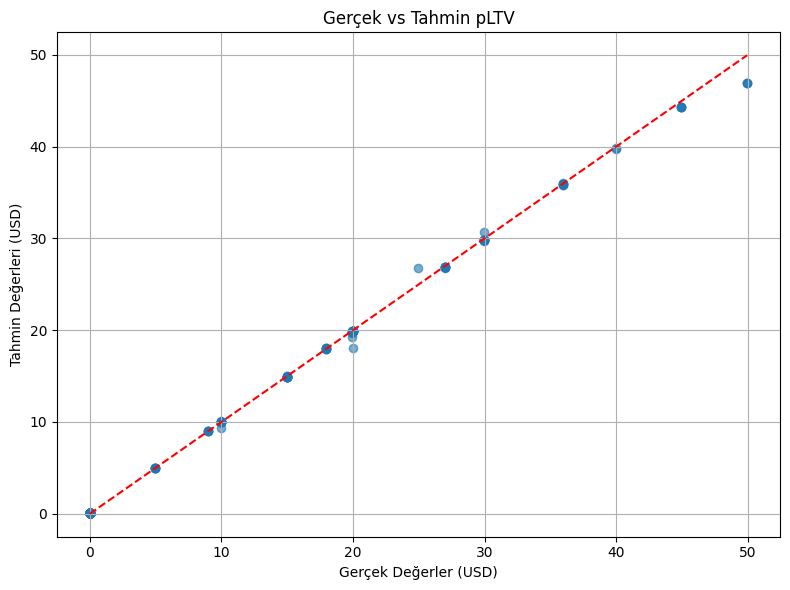

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Doğruluk çizgisi
plt.xlabel("Gerçek Değerler (USD)")
plt.ylabel("Tahmin Değerleri (USD)")
plt.title("Gerçek vs Tahmin pLTV")
plt.grid(True)
plt.tight_layout()
plt.show()


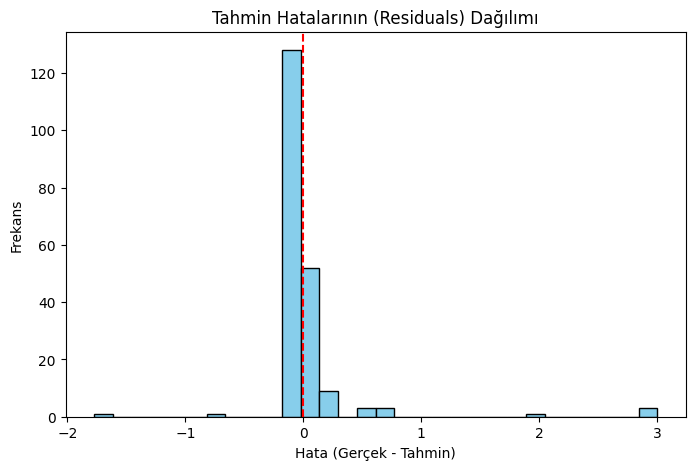

In [47]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, color='skyblue', edgecolor='black')
plt.title("Tahmin Hatalarının (Residuals) Dağılımı")
plt.xlabel("Hata (Gerçek - Tahmin)")
plt.ylabel("Frekans")
plt.axvline(0, color='red', linestyle='--')
plt.show()


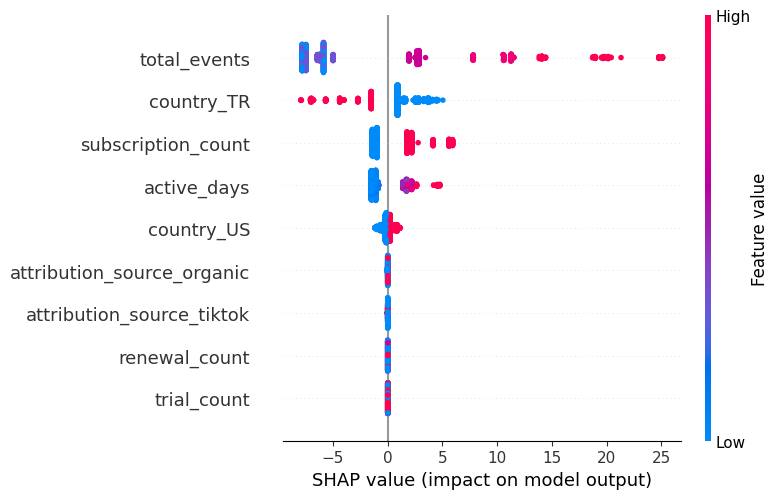

In [48]:
import shap
explainer = shap.TreeExplainer(lgb_reg)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)


In [49]:
from sklearn.model_selection import cross_val_score
import numpy as np

In [50]:
mae_scores = cross_val_score(lgb_reg, X, y, cv=5, scoring='neg_mean_absolute_error')
r2_scores = cross_val_score(lgb_reg, X, y, cv=5, scoring='r2')

print("Cross-Validated MAE Scores:", -mae_scores)
print(f"Ortalama MAE: ${-mae_scores.mean():.2f}")

print("\nCross-Validated R² Scores:", r2_scores)
print(f"Ortalama R²: {r2_scores.mean():.2f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 110
[LightGBM] [Info] Number of data points in the train set: 801, number of used features: 9
[LightGBM] [Info] Start training from score 9.715518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [51]:
df

,user_id,country,attribution_source,total_amount_usd,total_events,trial_count,subscription_count,renewal_count,first_event,last_event,active_days
0,1,US,instagram,0.00,3,1,0,0,2024-05-07,2024-05-24,17
1,2,NL,instagram,35.96,7,1,1,3,2024-10-12,2025-02-12,123
2,3,TR,tiktok,19.96,7,1,1,3,2024-10-15,2025-01-20,97
3,4,TR,tiktok,0.00,3,1,0,0,2024-08-28,2024-09-06,9
4,5,NL,organic,0.00,1,0,0,0,2024-04-03,2024-04-03,0
...,...,...,...,...,...,...,...,...,...,...,...
997,998,TR,instagram,0.00,1,0,0,0,2025-02-01,2025-02-01,0
998,999,NL,organic,26.97,6,1,1,2,2024-12-24,2025-03-08,74
999,1000,NL,organic,0.00,3,1,0,0,2025-02-13,2025-02-25,12
1000,1001,US,instagram,9.99,3,1,1,0,2025-02-25,2025-02-25,0


In [63]:
# Bruce Wayne için benzer özellikleri SQL'den al ve dummy encoding yap
query_bruce = """
SELECT
    COUNT(e.id) as total_events,
    COUNT(CASE WHEN e.event_name = 'trial_started' THEN 1 END) as trial_count,
    COUNT(CASE WHEN e.event_name = 'subscription_started' THEN 1 END) as subscription_count,
    COUNT(CASE WHEN e.event_name = 'subscription_renewed' THEN 1 END) as renewal_count,
    MIN(e.created_at) as first_event,
    MAX(e.created_at) as last_event,
    u.country,
    u.attribution_source
FROM users u
LEFT JOIN user_events e ON u.id = e.user_id
WHERE u.id = 1001  -- Bruce Wayne'in ID'si
GROUP BY u.id
LIMIT 1;
"""

In [64]:


bruce_sample = pd.read_sql_query(query_bruce, conn)


# Dummy encoding
bruce_encoded = pd.get_dummies(bruce_sample, columns=['country', 'attribution_source'], drop_first=True)



In [ ]:

for col in train_columns:
    if col not in bruce_encoded.columns:
        bruce_encoded[col] = 0

bruce_encoded = bruce_encoded[train_columns]
bruce_pltv = lgb_reg.predict(bruce_encoded)[0]
print(f"Bruce Wayne (#1001) için tahmini Lifetime Value (pLTV): ${bruce_pltv:.2f}")


Bruce Wayne (#1001) için tahmini Lifetime Value (pLTV): $8.99
